# YOLOv5 for Automatic License Plate Recognition

## Dataset: [Car License Plate Detection](https://www.kaggle.com/andrewmvd/car-plate-detection)
![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F793761%2Fc15e812b3ab9aad2c0694a2e1f7548e9%2FUntitled.png?generation=1590981584876269&alt=media)

## Repro [YOLOv5](https://github.com/ultralytics/yolov5)

In [1]:
# Clone YOLOv5 code
!git clone https://github.com/rkuo2000/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 3390, done.
remote: Total 3390 (delta 0), reused 0 (delta 0), pack-reused 3390
Receiving objects: 100% (3390/3390), 7.02 MiB | 28.31 MiB/s, done.
Resolving deltas: 100% (2276/2276), done.
/content/yolov5


In [2]:
!echo "train: /content/yolov5/Dataset/train/images" > data/alpr.yaml
!echo "val:   /content/yolov5/Dataset/train/images" >> data/alpr.yaml

!echo "nc : 1" >> data/alpr.yaml
!echo "names: ['license']" >> data/alpr.yaml

!cat data/alpr.yaml

train: /content/yolov5/Dataset/train/images
val:   /content/yolov5/Dataset/train/images
nc : 1
names: ['license']


## Prepare Dataset

In [3]:
import os
import zipfile
import numpy as np
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/DATASET_ALPR/ALPR-dataset.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [6]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/DATASET_ALPR/characters-ALPR.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [7]:
FILE_ROOT = "/tmp/"
IMAGE_PATH = FILE_ROOT + "images"  
ANNOTATIONS_PATH = FILE_ROOT + "annotations"

DATA_ROOT = "/content/yolov5/Dataset/"
DEST_IMAGES_PATH = "train/images"
DEST_LABELS_PATH = "train/labels"

In [8]:
!mkdir -p Dataset/train/labels

In [9]:
# copy images
!mkdir -p Dataset/train
!cp -rf /tmp/images Dataset/train

In [10]:
!mkdir -p Dataset/val
!cp -rf /tmp/images/Cars1*.png Dataset/val

### Convert COCO Annotations to YOLOv5 Labels

In [11]:
def cord_converter(size, box):
    """
    convert xml annotation to darknet format coordinates
    :param size： [w,h]
    :param box: anchor box coordinates [upper-left x,uppler-left y,lower-right x, lower-right y]
    :return: converted [x,y,w,h]
    """
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]
    
def save_file(img_jpg_file_name, size, img_box):
    classes = ['license']
    save_file_name = DATA_ROOT + DEST_LABELS_PATH + '/' + img_jpg_file_name + '.txt'
    print(save_file_name)
    file_path = open(save_file_name, "a+")
    for box in img_box:                  
        #cls_num = classes.index(box[0]) # find class_id
        cls_num = 0
        new_box = cord_converter(size, box[1:]) # convert box coord into YOLO x,y,w,h

        file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

    file_path.flush()
    file_path.close()
    
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    # print("img_name:", img_name)
    # print("image_info:(w,h,c)", img_w, img_h, img_c)
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        print("box:(c,xmin,ymin,xmax,ymax)", cls_name, x1, y1, x2, y2)
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
    # print(img_box)
    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_file(img_xml_file, [img_w, img_h], img_box)

In [12]:
files = os.listdir(ANNOTATIONS_PATH)
for file in files:
    print("file name: ", file)
    file_xml = file.split(".")
    get_xml_data(ANNOTATIONS_PATH, file_xml[0])

file name:  Cars71.xml
/tmp/annotations/Cars71.xml
box:(c,xmin,ymin,xmax,ymax) licence 254 144 284 152
box:(c,xmin,ymin,xmax,ymax) licence 86 150 125 161
/content/yolov5/Dataset/train/labels/Cars71.txt
file name:  Cars49.xml
/tmp/annotations/Cars49.xml
box:(c,xmin,ymin,xmax,ymax) licence 268 171 314 190
/content/yolov5/Dataset/train/labels/Cars49.txt
file name:  Cars272.xml
/tmp/annotations/Cars272.xml
box:(c,xmin,ymin,xmax,ymax) licence 170 81 316 121
/content/yolov5/Dataset/train/labels/Cars272.txt
file name:  Cars102.xml
/tmp/annotations/Cars102.xml
box:(c,xmin,ymin,xmax,ymax) licence 66 147 322 199
/content/yolov5/Dataset/train/labels/Cars102.txt
file name:  Cars193.xml
/tmp/annotations/Cars193.xml
box:(c,xmin,ymin,xmax,ymax) licence 306 193 344 214
/content/yolov5/Dataset/train/labels/Cars193.txt
file name:  Cars124.xml
/tmp/annotations/Cars124.xml
box:(c,xmin,ymin,xmax,ymax) licence 305 256 320 267
/content/yolov5/Dataset/train/labels/Cars124.txt
file name:  Cars340.xml
/tmp/anno

In [13]:
!mkdir -p Dataset/val/labels
!cp -rf Dataset/train/labels/Cars1*.txt Dataset/val/labels

In [14]:
!ls Dataset/train/labels

Cars0.txt    Cars166.txt  Cars231.txt  Cars298.txt  Cars363.txt  Cars429.txt
Cars100.txt  Cars167.txt  Cars232.txt  Cars299.txt  Cars364.txt  Cars42.txt
Cars101.txt  Cars168.txt  Cars233.txt  Cars29.txt   Cars365.txt  Cars430.txt
Cars102.txt  Cars169.txt  Cars234.txt  Cars2.txt    Cars366.txt  Cars431.txt
Cars103.txt  Cars16.txt   Cars235.txt  Cars300.txt  Cars367.txt  Cars432.txt
Cars104.txt  Cars170.txt  Cars236.txt  Cars301.txt  Cars368.txt  Cars43.txt
Cars105.txt  Cars171.txt  Cars237.txt  Cars302.txt  Cars369.txt  Cars44.txt
Cars106.txt  Cars172.txt  Cars238.txt  Cars303.txt  Cars36.txt	 Cars45.txt
Cars107.txt  Cars173.txt  Cars239.txt  Cars304.txt  Cars370.txt  Cars46.txt
Cars108.txt  Cars174.txt  Cars23.txt   Cars305.txt  Cars371.txt  Cars47.txt
Cars109.txt  Cars175.txt  Cars240.txt  Cars306.txt  Cars372.txt  Cars48.txt
Cars10.txt   Cars176.txt  Cars241.txt  Cars307.txt  Cars373.txt  Cars49.txt
Cars110.txt  Cars177.txt  Cars242.txt  Cars308.txt  Cars374.txt  Cars4.txt
Cars111.tx

## YOLOv5 Training

In [15]:
pip install PyYaml==5.1

     |████████████████████████████████| 274 kB 3.1 MB/s 
  Created wheel for PyYaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=b6beb70862dd6d6c39dcf94a3c5bbc7b8747f5c04bd4b1ed5343438be87a4cd0
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built PyYaml
  Attempting uninstall: PyYaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [16]:
%cat data/alpr.yaml

train: /content/yolov5/Dataset/train/images
val:   /content/yolov5/Dataset/train/images
nc : 1
names: ['license']


In [17]:
!python train.py --img 416 --batch 16 --epochs 100 --data data/alpr.yaml --cfg '/content/yolov5/models/yolov5s.yaml'

Using torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15109MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=False, cfg='/content/yolov5/models/yolov5s.yaml', data='data/alpr.yaml', device='', epochs=100, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', rect=False, resume=False, save_dir='runs/train/exp', single_cls=False, sync_bn=False, total_batch_size=16, weights='yolov5s.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
NumExpr defaulting to 2 threads.
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 

## YOLOv5 Detect

In [18]:
# Download OpenALPR Benchmarks
%cd ..
!git clone https://github.com/openalpr/benchmarks

/content
Cloning into 'benchmarks'...
remote: Enumerating objects: 1752, done.
remote: Total 1752 (delta 0), reused 0 (delta 0), pack-reused 1752
Receiving objects: 100% (1752/1752), 187.98 MiB | 48.62 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [19]:
%cd yolov5

/content/yolov5


In [20]:
!python detect.py --source '/content/benchmarks/endtoend/us' --conf 0.4 --weights runs/train/exp/weights/best.pt --save-txt

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=True, source='/content/benchmarks/endtoend/us', update=False, view_img=False, weights=['runs/train/exp/weights/best.pt'])
Using torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15109MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
image 1/222 /content/benchmarks/endtoend/us/0b86cecf-67d1-4fc0-87c9-b36b0ee228bb.jpg: 384x640 1 licenses, Done. (0.040s)
image 2/222 /content/benchmarks/endtoend/us/12c6cb72-3ea3-49e7-b381-e0cdfc5e8960.jpg: 384x640 Done. (0.016s)
image 3/222 /

In [21]:
!python detect.py --source '/content/benchmarks/endtoend/eu' --conf 0.4 --weights runs/train/exp/weights/best.pt --save-txt

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=True, source='/content/benchmarks/endtoend/eu', update=False, view_img=False, weights=['runs/train/exp/weights/best.pt'])
Using torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15109MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
image 1/108 /content/benchmarks/endtoend/eu/eu1.jpg: 480x640 2 licenses, Done. (0.040s)
image 2/108 /content/benchmarks/endtoend/eu/eu10.jpg: 544x640 2 licenses, Done. (0.038s)
image 3/108 /content/benchmarks/endtoend/eu/eu11.jpg: 416x640 1 li

In [22]:
!python detect.py --source '/content/benchmarks/endtoend/br' --conf 0.4 --weights runs/train/exp/weights/best.pt --save-txt

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=True, source='/content/benchmarks/endtoend/br', update=False, view_img=False, weights=['runs/train/exp/weights/best.pt'])
Using torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15109MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
image 1/115 /content/benchmarks/endtoend/br/AYO9034.jpg: 384x640 1 licenses, Done. (0.039s)
image 2/115 /content/benchmarks/endtoend/br/AZJ6991.jpg: 640x640 1 licenses, Done. (0.026s)
image 3/115 /content/benchmarks/endtoend/br/FZB9581.jpg: 64

### Display Detected Images

In [23]:
from IPython.display import Image

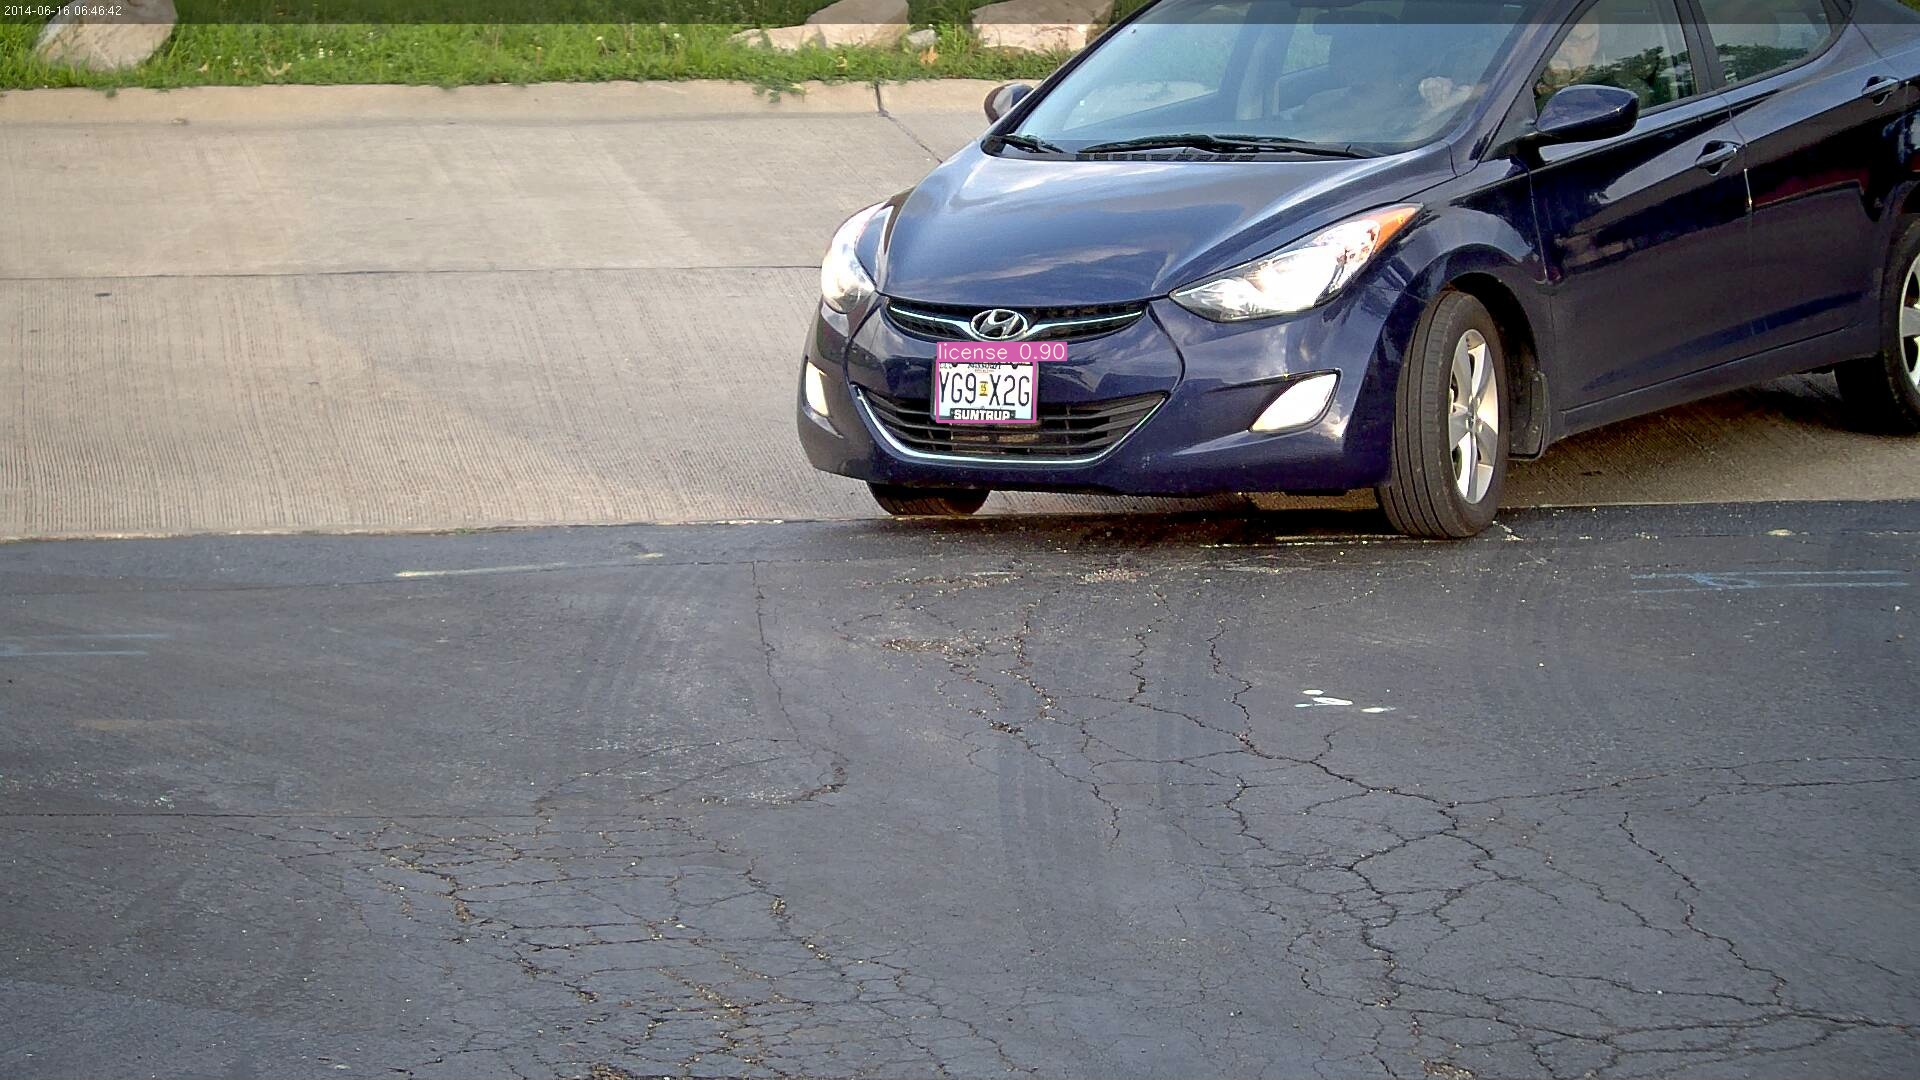

In [24]:
Image('runs/detect/exp/0b86cecf-67d1-4fc0-87c9-b36b0ee228bb.jpg')

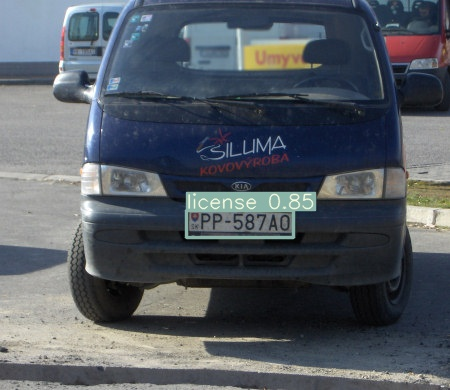

In [25]:
Image('runs/detect/exp2/test_001.jpg')

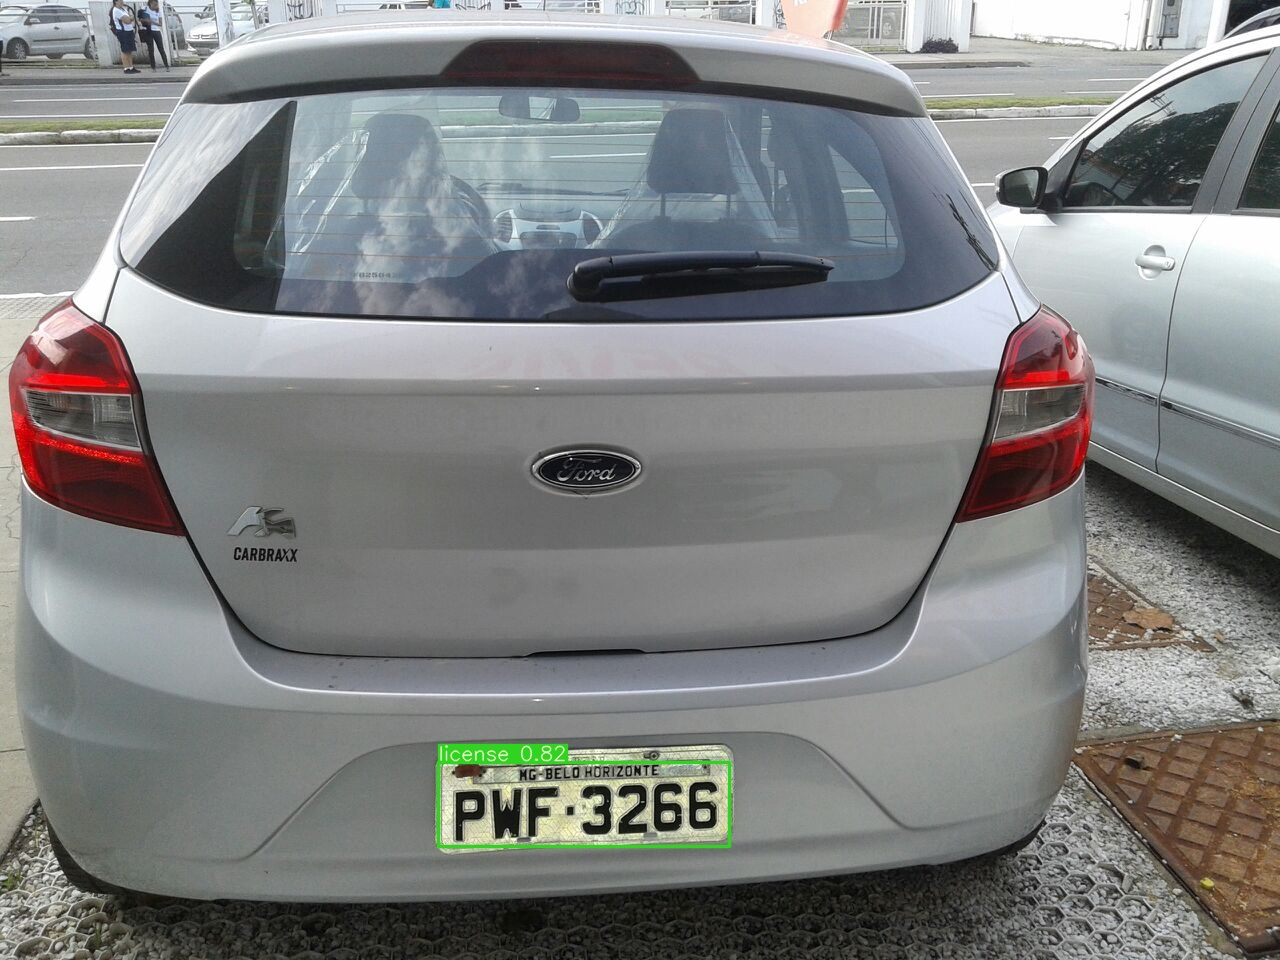

In [26]:
Image('runs/detect/exp3/PWF3266.jpg')

## detect boxes 


### get detected ALPR bounding box

In [27]:
# list saved .txt
!ls runs/detect/exp/labels

0b86cecf-67d1-4fc0-87c9-b36b0ee228bb.txt  wts-lg-000032.txt  wts-lg-000120.txt
1e241dc8-8f18-4955-8988-03a0ab49f813.txt  wts-lg-000033.txt  wts-lg-000121.txt
21d8c31d-3deb-494b-9c63-c0223306fd82.txt  wts-lg-000034.txt  wts-lg-000122.txt
22e54a62-57a8-4a0a-88c1-4b9758f67651.txt  wts-lg-000035.txt  wts-lg-000123.txt
316b64c0-55bf-4079-a1c0-d93f461a576f.txt  wts-lg-000036.txt  wts-lg-000124.txt
33fa5185-0286-4e8f-b775-46162eba39d4.txt  wts-lg-000037.txt  wts-lg-000125.txt
37170dd1-2802-4e38-b982-c5d07c64ff67.txt  wts-lg-000038.txt  wts-lg-000126.txt
3850ba91-3c64-4c64-acba-0c46b61ec0da.txt  wts-lg-000039.txt  wts-lg-000127.txt
4be2025c-09f7-4bb0-b1bd-8e8633e6dec1.txt  wts-lg-000040.txt  wts-lg-000128.txt
5b562a61-34ad-4f00-9164-d34abb7a38e4.txt  wts-lg-000041.txt  wts-lg-000129.txt
7fbfbe28-aecb-45be-bd05-7cf26acb3c5c.txt  wts-lg-000042.txt  wts-lg-000130.txt
c9368c55-210d-456c-a5ef-c310e60039ec.txt  wts-lg-000043.txt  wts-lg-000131.txt
car11.txt				  wts-lg-000044.txt  wts-lg-000132.txt


In [28]:
# read .txt to get x,y,w,h of ALPR
def read_txt(filepath):
    f = open(filepath, 'r')
    lines = f.readlines()
         
    # read objects from each line of .txt
    objects = []
    for line in lines:
        line=line.rstrip()
        obj = [int(float(i)) for i in line.split(' ')]
        objects.append(obj)
    #print(objects)
    return objects

In [29]:
#DETECT_PATH = '/kaggle/working/yolov5/runs/detect/exp/'
DETECT_PATH = 'runs/detect/exp2/'
IMG_NAME    = 'test_022'

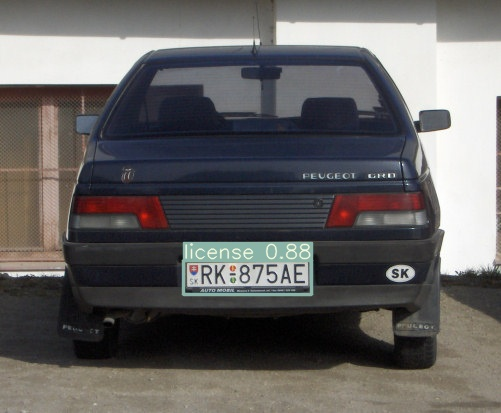

In [30]:
Image(DETECT_PATH+IMG_NAME+'.jpg')


In [31]:

import cv2
import matplotlib.pyplot as plt
img = cv2.imread(DETECT_PATH+IMG_NAME+'.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
lics = read_txt(DETECT_PATH +'labels/'+IMG_NAME+'.txt')


247 277 128 34


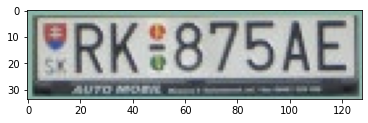

In [32]:
for lic in lics:
    c, x, y, w, h = lic
    print(x,y,w,h) # center of the bounding box
    img_alpr = img[y-int(h/2):y+int(h/2),x-int(w/2):x+int(w/2)]
    plt.imshow(img_alpr)
    #txt = pytesseract.image_to_string(img_alpr)
    #print(txt)
    
#    img = cv2.putText(img, txt, (x-int(w/2),y-int(h/2)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)   
#cv2.imwrite('alpr_us1.jpg', img)

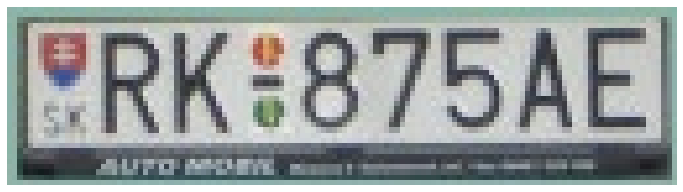

In [33]:
img_ori = img_alpr

height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')
plt.axis('off')
plt.savefig('Car.png',bbox_inches = 'tight')
plt.show()

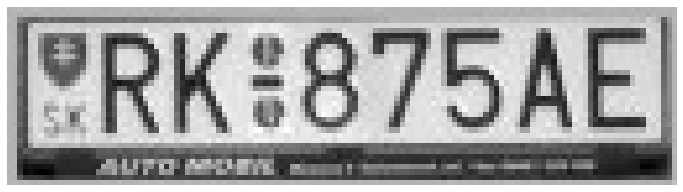

In [34]:
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.savefig('Car-GrayScale.png',bbox_inches = 'tight')
plt.show()

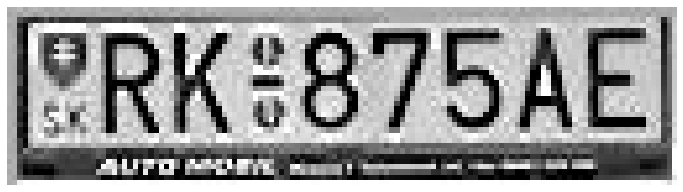

In [35]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.savefig('Car-Contrast.png',bbox_inches = 'tight')
plt.show()

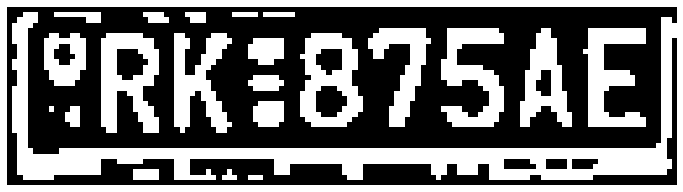

In [36]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')
plt.axis('off')
plt.savefig('Car-Adaptive-Thresholding.png',bbox_inches = 'tight')
plt.show()

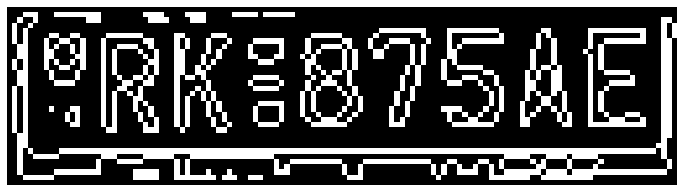

In [37]:
contours, _= cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)
plt.axis('off')
plt.savefig('Car-Contours.png',bbox_inches = 'tight')
plt.show()

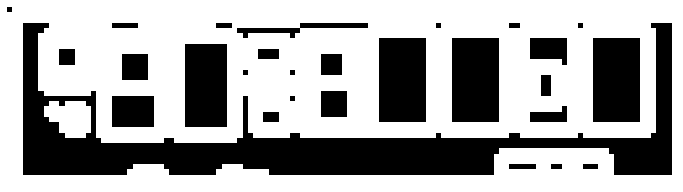

In [38]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('Car-Boxes.png',bbox_inches = 'tight')
plt.show()


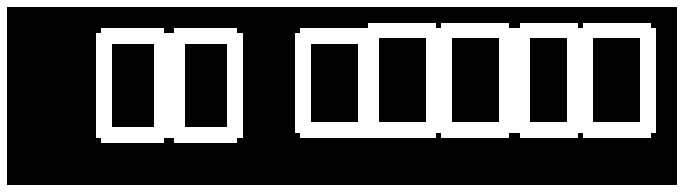

In [39]:
MIN_AREA = 30
MIN_WIDTH, MIN_HEIGHT, MAX_hight = 2, 15, 100

MIN_RATIO, MAX_RATIO = 0.1, 1.2

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT and d['h'] < MAX_hight \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('Car-Boxes-byCharSize.png',bbox_inches = 'tight')
plt.show()

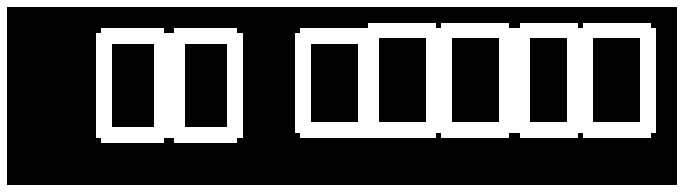

In [40]:


def find_chars(contour_list):
    matched_result_idx = []
    MAX_DIAG_MULTIPLYER = 5 # 5
    MAX_ANGLE_DIFF = 12.0 # 12.0
    MAX_AREA_DIFF = 10 # 0.5
    MAX_WIDTH_DIFF = 5
    MAX_HEIGHT_DIFF = 0.2
    MIN_N_MATCHED = 3 # 3
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('Car-Boxes-byContourArrangement.png',bbox_inches = 'tight')
plt.show()

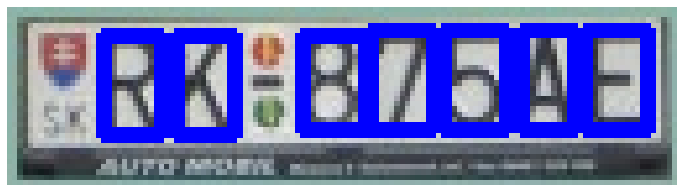

In [41]:
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
    temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(img_alpr, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(img_alpr, cmap='gray')
plt.axis('off')
plt.savefig('Car-OverlappingBoxes.png',bbox_inches = 'tight')
plt.show()


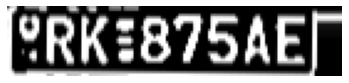

In [42]:
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')
    plt.axis('off')
    plt.savefig('Car-Plates(Rotated).png',bbox_inches = 'tight')
    plt.show()

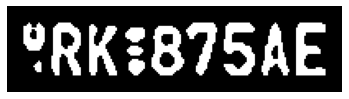

In [43]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')
    plt.axis('off')
    plt.savefig('Car-Plates(Thresholding).png',bbox_inches = 'tight')
    plt.show()
    break

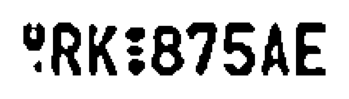

In [44]:
img = 255-img_result
plt.imshow(img, 'gray')
plt.axis('off')
plt.savefig('Car-Plates(Negative).png',bbox_inches = 'tight')
plt.show()
#border is black because remember i set the background to be black

In [45]:
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.axis('off')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [46]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))

    LP_WIDTH = img_lp.shape[0]
    LP_HEIGHT = img_lp.shape[1]

    # Make borders white
    img_lp[0:3,:] = 255
    img_lp[:,0:3] = 255
    img_lp[72:75,:] = 255
    img_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/12,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       LP_HEIGHT/7]
    plt.imshow(img_lp, cmap='gray')
    plt.axis('off')
    plt.show()
    cv2.imwrite('contour.jpg', img_lp)
    

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_lp)

    return char_list

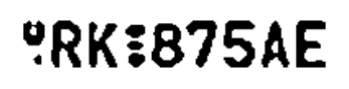

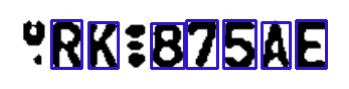

In [47]:
char = segment_characters(img)

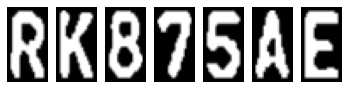

In [48]:

for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.savefig('Car-Plates-Char(Seperated).png',bbox_inches = 'tight')

In [49]:
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from keras.models import Sequential,model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
import tensorflow.keras.backend as K

In [50]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = '/tmp/data/'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [51]:
def f1score(y, y_pred):
    return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
    return tf.py_function(f1score, (y, y_pred), tf.double)

In [52]:
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")

def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./{}.h5".format(model_name))
    return model

In [53]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))


model.add(MaxPooling2D(pool_size=(4,4)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=[custom_f1score])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 128)       131200    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 128)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                        

In [55]:
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_custom_f1score') > 0.99):
              self.model.stop_training = True

In [56]:
batch_size = 1
callbacks = [stop_training_callback()]
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 80, verbose=1, callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/80
864/864 [==============================] - 19s 8ms/step - loss: 3.3184 - custom_f1score: 0.0868 - val_loss: 2.3601 - val_custom_f1score: 0.2783
Epoch 2/80
864/864 [==============================] - 6s 7ms/step - loss: 1.7277 - custom_f1score: 0.4769 - val_loss: 0.7182 - val_custom_f1score: 0.7812
Epoch 3/80
864/864 [==============================] - 7s 8ms/step - loss: 0.7298 - custom_f1score: 0.7593 - val_loss: 0.5548 - val_custom_f1score: 0.8244
Epoch 4/80
864/864 [==============================] - 6s 7ms/step - loss: 0.4470 - custom_f1score: 0.8495 - val_loss: 0.3467 - val_custom_f1score: 0.8765
Epoch 5/80
864/864 [==============================] - 6s 7ms/step - loss: 0.3654 - custom_f1score: 0.8738 - val_loss: 0.2388 - val_custom_f1score: 0.9122
Epoch 6/80
864/864 [==============================] - 6s 7ms/step - loss: 0.3123 - custom_f1score: 0.9097 - val_loss: 0.1821 - val_custom_f1score: 0.9196
Epoch 7/80
864/864 [==============================] - 6s 7ms/step - loss: 0

In [57]:
store_keras_model(model, 'model_LicensePlate')

Saved model to disk


In [58]:
pre_trained_model = load_keras_model('model_LicensePlate')
model = pre_trained_model 

In [74]:
print(pre_trained_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 128)       131200    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 128)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                        

In [81]:
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img 
    return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_=model.predict(img) 
        classes_x=np.argmax(y_[0]> 0.5).astype("int32") #
        character = dic[classes_x]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

RK875AE


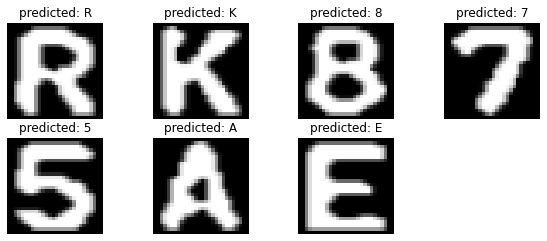

In [82]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    title_obj = plt.title(f'predicted: {show_results()[i]}')
    plt.setp(title_obj, color='black')
    plt.axis('off')
plt.show()

In [83]:
lics = read_txt(DETECT_PATH +'labels/'+IMG_NAME+'.txt')
for lic in lics:
    c, x, y, w, h = lic
    print(x,y,w,h) # center of the bounding box

247 277 128 34


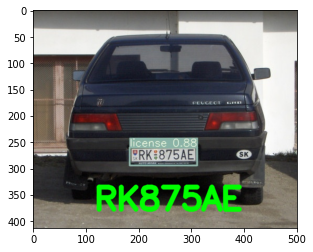

In [84]:
text = show_results()
font = cv2.FONT_HERSHEY_SIMPLEX
img =cv2.imread(DETECT_PATH+IMG_NAME+'.jpg')

res = cv2.putText(img, text=text, org=((x-130), (y+100)), fontFace=font, fontScale=2, color=(0,255,0), thickness=8, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, 390, 348, 255, 115)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
